In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
#matplotlib.rcParams['mathtext.fontset'] = 'stix'
#matplotlib.rcParams['font.family'] = 'STIXGeneral'
#matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 8) 
matplotlib.rc('ytick', labelsize = 8)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm

from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44305,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:38533,Total threads: 4
Dashboard: /proxy/44385/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:36133,


In [3]:
db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_control_hh5.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_control'

In [4]:
start_time = '2297-01-01'
end_time = '2301-12-31'

def var_td(variable):
    out = cc.querying.getvar(expt = expt, variable = variable, session = session, start_time = start_time, end_time = end_time, use_cftime = True)
    out = out.sel(time = slice(start_time, end_time)).mean('time')
    return out

def var_ti(variable):
    out = cc.querying.getvar(expt = expt, variable = variable, session = session, n = 1)
    return out

geolon_t = var_ti('geolon_t')
geolat_t = var_ti('geolat_t')

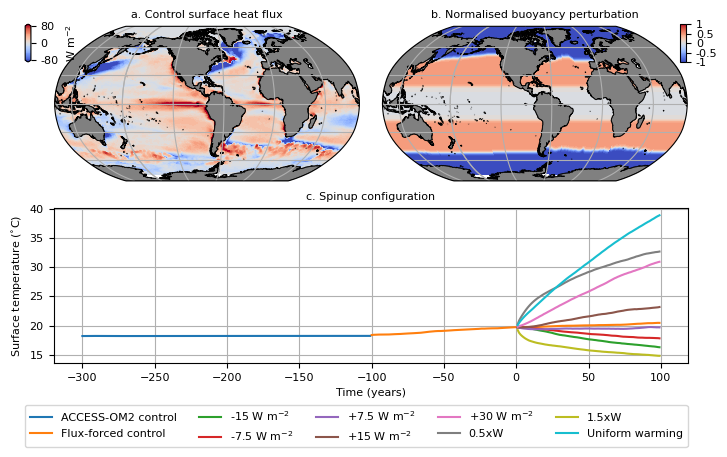

In [5]:
import matplotlib.pyplot as plt
import numpy as np
 
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(3.5*1.2)
fig.set_figwidth(6*1.2)
 
ax1 = plt.subplot2grid(shape=(6, 6), loc=(0, 0), rowspan = 3, colspan=3, projection=ccrs.Robinson(central_longitude = -80))
ax2 = plt.subplot2grid(shape=(6, 6), loc=(0, 3), rowspan = 3, colspan=3, projection=ccrs.Robinson(central_longitude = -80))
ax3 = plt.subplot2grid(shape=(6, 6), loc=(3, 0), rowspan = 3, colspan=6)
 
## Part 1:  Net surface heating
net_sfc = var_td('net_sfc_heating')

# assign
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

net_sfc = net_sfc.assign_coords({'latitude': geolat_t, 'longitude': geolon_t})

#ax1 = plt.axes(projection=ccrs.Robinson(central_longitude = -80))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels=False)

p1 = net_sfc.plot.contourf(ax=ax1,
                       x='longitude', y='latitude',
                       levels=41, vmin=-80, vmax=80,
                       cmap='coolwarm',
                       transform=ccrs.PlateCarree(),
                       add_colorbar=False, rasterized=True, zorder = -20)

ax1.set_title('a. Control surface heat flux', fontsize = 8)

ax_cb = plt.axes([0.05, 0.85, 0.008, 0.09])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', ticks=[-80, 0, 80])
cb.ax.set_ylabel('W m$^{-2}$', fontsize = 8)
cb.ax.set_yticklabels(['-80', '0', '80'])
    

## Part 2: Buoyancy perturbation
import netCDF4 as nc
from netCDF4 import Dataset

nc_file = '/scratch/x77/db6174/025deg_inputs/flux_forced_pos10W/heat_mask.nc'
hmask = xr.open_dataset(nc_file)
hmask = hmask.to_array().mean('variable')

hblt = var_td('hblt')
hmask = hmask.where(~np.isnan(hblt))

# assign
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

hmask = hmask.assign_coords({'latitude': geolat_t, 'longitude': geolon_t})

ax2.coastlines(resolution='50m')
ax2.add_feature(land_50m)
gl = ax2.gridlines(draw_labels=False)

p1 = (hmask/10).plot.contourf(ax=ax2,
                       x='longitude', y='latitude',
                       levels=41, vmin=-1, vmax=1,
                       cmap='coolwarm',
                       transform=ccrs.PlateCarree(),
                       add_colorbar=False, rasterized=True, zorder = -20)

ax2.set_title('b. Normalised buoyancy perturbation', fontsize = 8)

ax_cb = plt.axes([0.96, 0.85, 0.008, 0.09])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', ticks=[-1, -0.5, 0, 0.5, 1])
#cb.ax.set_ylabel('W m$^{-2}$', fontsize = 8)
cb.ax.set_ylabel('', fontsize = 8)
cb.ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'], fontsize = 8)

    
## Part 3: Spin up
name = ['ffm_Neg10W', 'ffm_Neg5W', 'ffm_Pos5W', 'ffm_Pos10W', 'ffm_Pos20W', 'ffm_050x.nc', 'ffm_150x.nc', 'pos5W_globe.nc']
lab = ['ACCESS-OM2 control', 'Flux-forced control', '-15 W m$^{-2}$', '-7.5 W m$^{-2}$', '+7.5 W m$^{-2}$', '+15 W m$^{-2}$', '+30 W m$^{-2}$', '0.5xW', '1.5xW', 'Uniform warming']

variable = xr.open_dataset('NETCDF/SST_expts/ffm_base.nc')
variable = variable.to_array().mean('variable')
ax3.plot(np.arange(-300, -100), variable, label = lab[0])
    
st = '2101-01-01'
et = '2300-12-31'

variable = cc.querying.getvar(expt = '025deg_jra55_ryf_control', session = session, variable = 'temp_surface_ave', start_time = st, end_time = et)
variable = variable.sel(time = slice(st, et))
variable = variable.coarsen({"time": 365}, boundary = "trim").mean()
ax3.plot(np.arange(-100, 100), variable.values, label = lab[1])

for i, j in enumerate(name):
    variable = xr.open_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/Expt_config/' + name[i])
    variable = variable.to_array().mean('variable')
    ax3.plot(np.arange(1, 100), variable.values, label = lab[2+i])
ax3.grid()
ax3.set_xlabel('Time (years)', fontsize = 8)
ax3.set_ylabel('Surface temperature ($^{\circ}$C)', fontsize = 8)
ax3.set_title('c. Spinup configuration', fontsize = 8)

fig.tight_layout(pad = 1.5)
fig.legend(bbox_to_anchor = (0.51, -0.08), loc = 'lower center', ncol = 5, fontsize = 8)

#plt.savefig('/home/156/db6174/x77/Flux_forced_models/2022_paper_figures/Figures/Fig1/expt_config.jpg', dpi = 300, bbox_inches = 'tight')